# Crossover Spark processing of user geolocation

This code will do the following:


    1. create the region dataframe(df)
    2. create the poi df
    3. add region column to the poi df
    4. create the user df
    5. add the region column to the user df


In [24]:
from shapely.geometry import *
import fiona 
import geospark
import pandas as pd
import geopandas
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.cm import *
from IPython.display import Image as ImageShow
from pyspark.sql import *
import pyspark.sql.functions as f
import pyspark.sql.types as types
from pyspark.sql.types import *
from math import radians, cos, sin, asin, sqrt
from geospark.sql.types import GeometryType
from geopandas import GeoDataFrame 
import rtree
from scipy.spatial import cKDTree

In [2]:
spark = (
    SparkSession
    .builder
    .appName('crossover')
    .master('local[6]')
    .getOrCreate()
)

In [25]:
spark

### Create the region dataframe

This is create in a GeoDataFrame in order to read the Polygon column from the shape file.

In [35]:
region_columns = ['region_id','region_parent','region_name','geometry_polygon','geometry']

region_filename = "NUTS_Level_1_January_2018_Full_Extent_Boundaries_in_the_United_Kingdom.shp"

region_geopd = GeoDataFrame.from_file(region_filename)
region_geopd = region_geopd[['objectid', 'nuts118nm', 'geometry']]
#region_geopd.rename(columns={"geometry": "polygon_geometry"}, inplace=True)

region_geopd

,objectid,nuts118nm,geometry
0,1,North East (England),"MULTIPOLYGON (((398210.896 657405.599, 398214...."
1,2,North West (England),"POLYGON ((357067.497 586765.599, 357029.100 58..."
2,3,Yorkshire and The Humber,"POLYGON ((478789.598 519220.104, 478794.701 51..."
3,4,East Midlands (England),"POLYGON ((512572.598 414469.499, 512619.702 41..."
4,5,West Midlands (England),"POLYGON ((402840.498 368845.598, 402862.397 36..."
5,6,East of England,"MULTIPOLYGON (((591658.902 347540.397, 591666...."
6,7,London,"POLYGON ((531643.597 200802.700, 531658.603 20..."
7,8,South East (England),"MULTIPOLYGON (((490173.603 256107.999, 490234...."
8,9,South West (England),"MULTIPOLYGON (((416361.796 245471.004, 416367...."
9,10,Wales,"MULTIPOLYGON (((312661.601 385723.097, 312730...."


In [36]:
region = region_geopd.to_crs('EPSG:7931')

In [37]:
region.crs

<Geographic 3D CRS: EPSG:7931>
Name: ETRF2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: Europe - ETRS89
- bounds: (-16.1, 32.88, 40.18, 84.17)
Datum: European Terrestrial Reference Frame 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

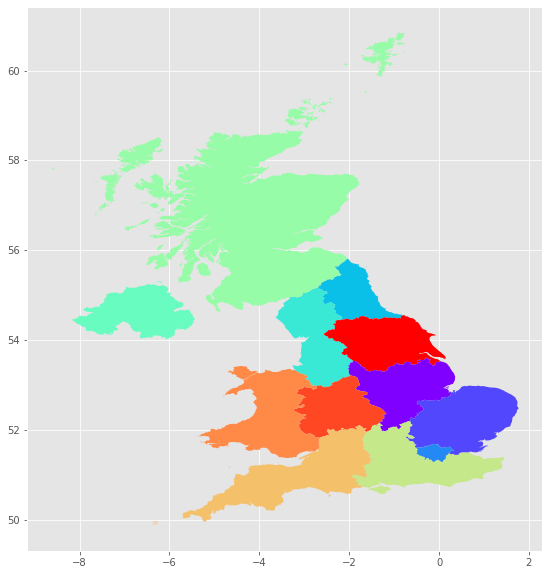

In [7]:
region.plot(cmap = 'rainbow', column = 'nuts118nm', figsize = (10,10))

In [8]:
type(region.geometry[6])

shapely.geometry.polygon.Polygon

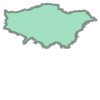

In [9]:
region.geometry[6]

In [10]:
london = region.loc[region['nuts118nm'] == 'London', 'geometry'].squeeze()

In [11]:
type(london)

shapely.geometry.polygon.Polygon

### Create the poi dataframe

First, create a pandas dataframe, then convert it to a geopandas dataframe by the creation of the POINT geometry

In [28]:
#create pd dataframe from poi file
poi_file = "./FinalPOIApril2020.csv"
poi_columns = ['poi_id','brand','category','category_group','poi_lat','poi_long','category_distance','hidden','region']

poi_pd = pd.read_csv(poi_file,names=poi_columns, header=0)
poi_pd.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,poi_id,brand,category,category_group,poi_lat,poi_long,category_distance,hidden,region
0,1,Accessorize,Clothing - Female,Retail - clothing & footwear,49.18436,-2.10590,2,NaN,NaN
1,2,Accessorize,Clothing - Female,Retail - clothing & footwear,50.71488,-2.43695,2,NaN,NaN
2,3,Accessorize,Clothing - Female,Retail - clothing & footwear,50.75386,-1.84098,2,NaN,NaN
3,4,Accessorize,Clothing - Female,Retail - clothing & footwear,50.76870,0.28513,2,NaN,NaN
4,5,Accessorize,Clothing - Female,Retail - clothing & footwear,50.88442,-1.24562,2,NaN,NaN


In [29]:
len(poi_pd)

#number of records =  256 961

256961

In [31]:
poi_pd.count()

poi_id               256961
brand                 51954
category             220957
category_group       256961
poi_lat              256961
poi_long             256961
category_distance    256961
hidden                41018
region                    0
dtype: int64

In [32]:
poi_pd.dtypes

poi_id                 int64
brand                 object
category              object
category_group        object
poi_lat              float64
poi_long             float64
category_distance      int64
hidden                object
region               float64
dtype: object

In [33]:
#create a geodataframe from the pd dataframe so to create the POINT datatype 
crs = {'init': 'EPSG:7931'}

geometry = [Point(xy) for xy in zip(poi_pd['poi_long'],poi_pd['poi_lat'])]
poi_geopd = geopandas.GeoDataFrame(poi_pd, \
                                   #geometry=geopandas.points_from_xy(poi_pd.poi_long, poi_pd.poi_lat), \
                                   geometry=geometry, \
                                   crs=crs)
poi_geopd.head()
#poi_geopd.rename(columns={"geometry": "point_geometry"}, inplace=True)


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,poi_id,brand,category,category_group,poi_lat,poi_long,category_distance,hidden,region,geometry
0,1,Accessorize,Clothing - Female,Retail - clothing & footwear,49.18436,-2.10590,2,NaN,NaN,POINT (-2.10590 49.18436)
1,2,Accessorize,Clothing - Female,Retail - clothing & footwear,50.71488,-2.43695,2,NaN,NaN,POINT (-2.43695 50.71488)
2,3,Accessorize,Clothing - Female,Retail - clothing & footwear,50.75386,-1.84098,2,NaN,NaN,POINT (-1.84098 50.75386)
3,4,Accessorize,Clothing - Female,Retail - clothing & footwear,50.76870,0.28513,2,NaN,NaN,POINT (0.28513 50.76870)
4,5,Accessorize,Clothing - Female,Retail - clothing & footwear,50.88442,-1.24562,2,NaN,NaN,POINT (-1.24562 50.88442)


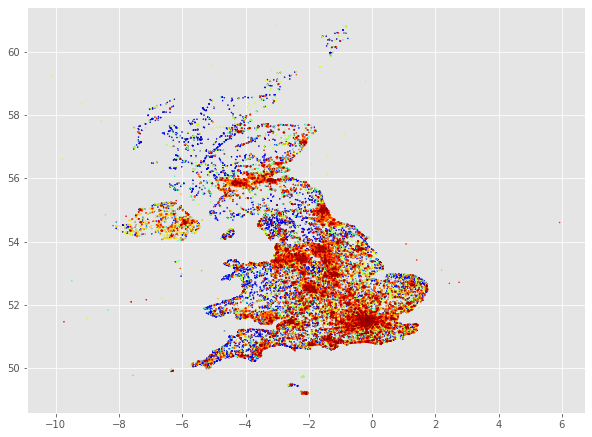

In [16]:
poi_geopd.plot(cmap = 'jet', column = 'category', figsize = (10,15), markersize = 1)


In [17]:
poi_geopd.crs

<Geographic 2D CRS: +init=epsg:7931 +type=crs>
Name: ETRF2000
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: Europe - ETRS89
- bounds: (-16.1, 32.88, 40.18, 84.17)
Datum: European Terrestrial Reference Frame 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Overlay POIs with Regions on Map

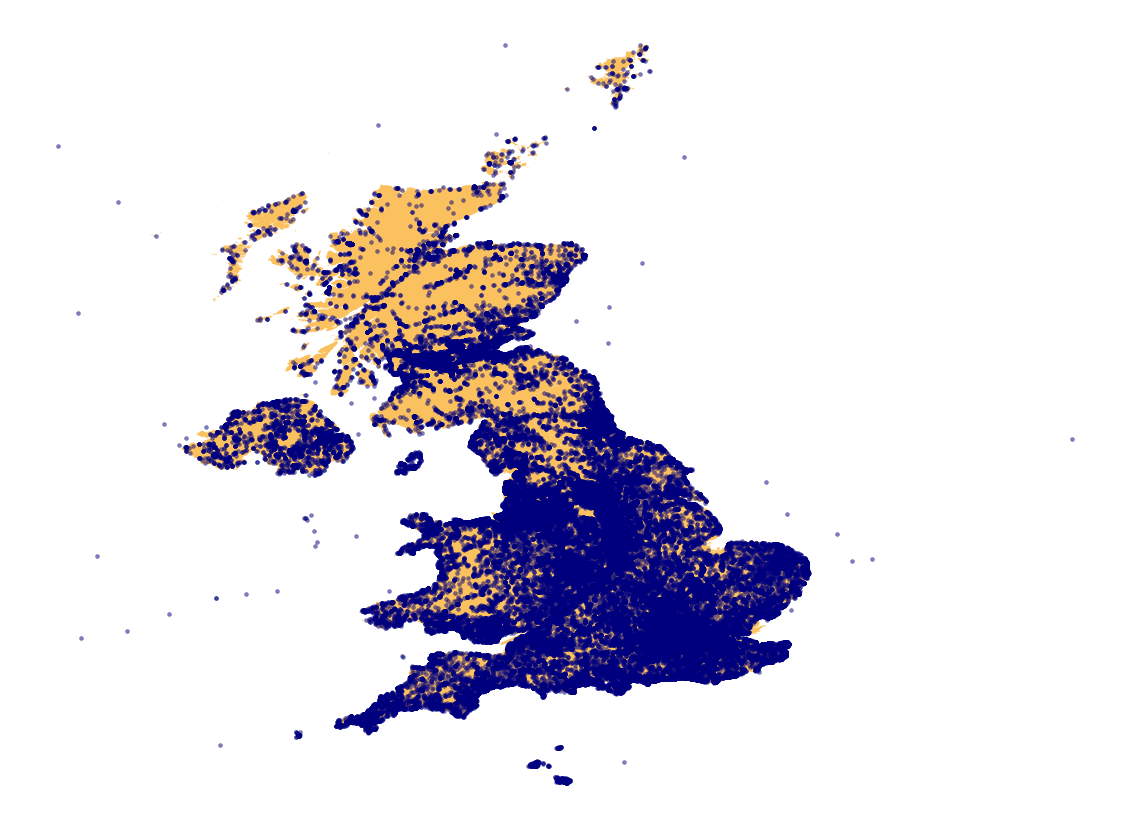

In [54]:
ax = region.plot(color='C4', figsize = (20,20))

poi_geopd.plot(ax = ax, alpha=0.5, color='navy',  markersize = 15)
ax.set_axis_off()

### Add the new region to the poi dataframe

In [38]:
poi_region = geopandas.sjoin(poi_geopd,region, op='within', how='left')
poi_region.count()


/usr/local/lib/python3.7/dist-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:7931 +type=crs != EPSG:7931)
  "(%s != %s)" % (left_df.crs, right_df.crs)


poi_id               256961
brand                 51954
category             220957
category_group       256961
poi_lat              256961
poi_long             256961
category_distance    256961
hidden                41018
region                    0
geometry             256961
index_right          255977
objectid             255977
nuts118nm            255977
dtype: int64

In [40]:
poi_region['nuts118nm'].value_counts()

London                      40694
South East (England)        33012
North West (England)        29092
Scotland                    24497
West Midlands (England)     22038
Yorkshire and The Humber    21406
South West (England)        21235
East of England             20430
East Midlands (England)     15812
Wales                       11751
North East (England)        11499
Northern Ireland             4511
Name: nuts118nm, dtype: int64

In [42]:
poi_region[poi_region['nuts118nm'].isnull()].count()

poi_id               984
brand                158
category             816
category_group       984
poi_lat              984
poi_long             984
category_distance    984
hidden               162
region                 0
geometry             984
index_right            0
objectid               0
nuts118nm              0
dtype: int64

Remove POIs that dont have an assigned region and clean up dataset

In [59]:
poi_region = poi_region[poi_region['nuts118nm'].notna()]

 
poi_interim = poi_region[['poi_id','brand','category','category_group','poi_lat','poi_long','category_distance','hidden','nuts118nm']]
poi = poi_interim.rename(columns={'nuts118nm': 'region'}, copy=True)
poi


,poi_id,brand,category,category_group,poi_lat,poi_long,category_distance,hidden,region
1,2,Accessorize,Clothing - Female,Retail - clothing & footwear,50.71488,-2.43695,2,NaN,South West (England)
2,3,Accessorize,Clothing - Female,Retail - clothing & footwear,50.75386,-1.84098,2,NaN,South West (England)
3,4,Accessorize,Clothing - Female,Retail - clothing & footwear,50.76870,0.28513,2,NaN,South East (England)
4,5,Accessorize,Clothing - Female,Retail - clothing & footwear,50.88442,-1.24562,2,NaN,South East (England)
5,6,Accessorize,Clothing - Female,Retail - clothing & footwear,51.00434,-0.93678,2,NaN,South East (England)
...,...,...,...,...,...,...,...,...,...
256956,256957,NaN,Zoos Aquariums & Wildlife,Parks gardens & nature,56.62022,-6.06822,6,NaN,Scotland
256957,256958,NaN,Zoos Aquariums & Wildlife,Parks gardens & nature,57.11004,-3.97580,6,NaN,Scotland
256958,256959,NaN,Zoos Aquariums & Wildlife,Parks gardens & nature,57.13982,-2.17572,6,NaN,Scotland
256959,256960,NaN,Zoos Aquariums & Wildlife,Parks gardens & nature,57.53946,-5.50957,6,NaN,Scotland


In [54]:
type(poi)

pandas.core.frame.DataFrame

In [60]:
poi.to_csv('poi_cleansed.csv',index = False)

### Add region to user location table

First create a spark dataframe for the user location 1.3 billion records

Row(userid='000019e5-4a53-48a8-8e35-a0783f820f5f', event_date='2019-05-23 09:53:59.781', latitude=Decimal('53.397247314453125'), longitude=Decimal('-2.497413192183255'), round_longitude=Decimal('53.39'), round_latitude=Decimal('-2.49'), sround_longitude=Decimal('53.39724'), sround_latitude=Decimal('-2.49741'), bround_longitude=Decimal('53.39720'), bround_latitude=Decimal('-2.49740'), mround_longitude=Decimal('53.39700'), mround_latitude=Decimal('-2.49700'), geopoint='010100000000000000D9B24A40563588C4B3FA03C0', postcode='WA3 6')

## Visualise the points in geopandas for the sample user location data

In [4]:
user_schema = types.StructType([StructField('userid', StringType(), False),
                        StructField('event_date', StringType(), True),
                        StructField('latitude', DecimalType(18,15), False),
                        StructField('longitude', DecimalType(18,15), False),
                        StructField('round_longitude', DecimalType(6,2), False),  
                        StructField('round_latitude', DecimalType(6,2), True),
                        StructField('sround_longitude', DecimalType(9,5), True),
                        StructField('sround_latitude', DecimalType(9,5), True),
                        StructField('bround_longitude', DecimalType(9,5), True),
                        StructField('bround_latitude', DecimalType(9,5), True),
                        StructField('mround_longitude', DecimalType(9,5), True),
                        StructField('mround_latitude', DecimalType(9,5), True),
                        StructField('geopoint', StringType(), True),
                        StructField('postcode', StringType(), True)])

user_raw = spark.read.format('csv')  \
                .schema(user_schema)  \
                .load("./xm_ls_26thMay_for_beatrice*.csv")

user_spark = user_raw.select([c for c in user_raw.columns if c in ['userid','event_date','latitude','longitude']])

user_spark.show()

+--------------------+--------------------+------------------+------------------+
|              userid|          event_date|          latitude|         longitude|
+--------------------+--------------------+------------------+------------------+
|000019e5-4a53-48a...|2019-05-23 09:53:...|53.397247314453125|-2.497413192183255|
|00002c68-089b-4e9...|2019-05-23 12:31:...|51.919342041015625|-0.699813561514671|
|00002c68-089b-4e9...|2019-05-23 12:31:...|51.919342041015625|-0.699813561514671|
|00007903-4cae-4e0...|2019-05-23 10:17:...|52.618834700000000|-1.073803800000000|
|00007903-4cae-4e0...|2019-05-23 10:17:...|52.618834700000000|-1.073803800000000|
|00007903-4cae-4e0...|2019-05-23 10:17:...|52.618834700000000|-1.073803800000000|
|00007903-4cae-4e0...|2019-05-23 11:59:...|52.637397700000000|-1.072081700000000|
|00007903-4cae-4e0...|2019-05-23 11:59:...|52.637397700000000|-1.072081700000000|
|00007903-4cae-4e0...|2019-05-23 11:59:...|52.637397700000000|-1.072081700000000|
|00007903-4cae-4

In [22]:
print(user_spark.rdd.getNumPartitions())
#print(df.rdd.getNumPartitions())

#user_spark.groupBy(f.spark_partition_id).count

user_spark.withColumn("partitionId", f.spark_partition_id()).groupBy("partitionId").count().show()

6
+-----------+------+
|partitionId| count|
+-----------+------+
|          1|353418|
|          3|339747|
|          5|324568|
|          4|333593|
|          2|353212|
|          0|353223|
+-----------+------+



In [52]:
user_kdtree = cKDTree(user_spark[['latitude', 'longitude']] )

ValueError: setting an array element with a sequence.

In [ ]:
partitionBy(self, numPartitions, partitionFunc=portable_hash)
Return a copy of the RDD partitioned using the specified partitioner.

In [5]:
user_pd = user_spark.toPandas()

In [6]:
user_pd.head()

,userid,event_date,latitude,longitude
0,000019e5-4a53-48a8-8e35-a0783f820f5f,2019-05-23 09:53:59.781,53.397247314453125,-2.497413192183255
1,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.953,51.919342041015625,-0.699813561514671
2,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.987,51.919342041015625,-0.699813561514671
3,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618834700000000,-1.073803800000000
4,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618834700000000,-1.073803800000000


In [5]:
user_files = "./xm_ls_26thMay_for_beatrice1.csv"
user_columns = ['userid','event_date','latitude','longitude','round_longitude','round_latitude', \
               'sround_longitude','sround_latitude','bround_longitude','bround_latitude','mround_longitude', \
               'mround_latitude','geopoint','postcode']
user_pd = pd.read_csv(user_files, names=user_columns)

user_min_cols = user_pd[['userid','event_date','latitude','longitude']]
user_min_cols.head()

,userid,event_date,latitude,longitude
0,000019e5-4a53-48a8-8e35-a0783f820f5f,2019-05-23 09:53:59.781,53.397247,-2.497413
1,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.953,51.919342,-0.699814
2,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.987,51.919342,-0.699814
3,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618835,-1.073804
4,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618835,-1.073804


In [7]:
crs = {'init': 'EPSG:7931'}

geometry = [Point(xy) for xy in zip(user_pd['longitude'],user_pd['latitude'])]
user = geopandas.GeoDataFrame(user_pd, \
                                   #geometry=geopandas.points_from_xy(poi_pd.poi_long, poi_pd.poi_lat), \
                                   geometry=geometry, \
                                   crs=crs)
user

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,userid,event_date,latitude,longitude,geometry
0,000019e5-4a53-48a8-8e35-a0783f820f5f,2019-05-23 09:53:59.781,53.397247314453125,-2.497413192183255,POINT (-2.49741 53.39725)
1,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.953,51.919342041015625,-0.699813561514671,POINT (-0.69981 51.91934)
2,00002c68-089b-4e9b-99aa-3b6cd62f3bcd,2019-05-23 12:31:17.987,51.919342041015625,-0.699813561514671,POINT (-0.69981 51.91934)
3,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618834700000000,-1.073803800000000,POINT (-1.07380 52.61883)
4,00007903-4cae-4e07-ac34-6aa59b8cbe3b,2019-05-23 10:17:17.238,52.618834700000000,-1.073803800000000,POINT (-1.07380 52.61883)
...,...,...,...,...,...
2057756,fffe449b-9b93-4851-a50d-a01633c0aac6,2019-05-23 16:37:22.805,51.735779300000000,-0.018518900000000,POINT (-0.01852 51.73578)
2057757,fffe7352-ec34-44c3-9f88-e25770a3d6ff,2019-05-23 20:17:05.898,51.568779130968460,0.009222120742247,POINT (0.00922 51.56878)
2057758,ffff6647-8df4-4846-803c-53d0bf7ee18e,2019-05-23 06:51:10.804,53.512662900000000,-2.369420400000000,POINT (-2.36942 53.51266)
2057759,ffffe033-708c-4456-b884-3880a63cc5b0,2019-05-23 21:57:45.65,51.522186279296875,-0.138604707684908,POINT (-0.13860 51.52219)


In [8]:
type(user)

geopandas.geodataframe.GeoDataFrame

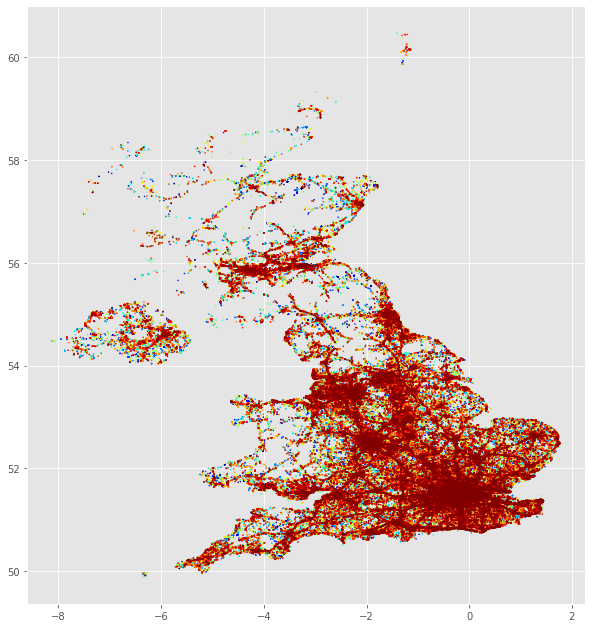

In [9]:
user.plot(cmap = 'jet', figsize = (10,15), markersize = 0.1)

In [ ]:
spark_region = spark.createDataFrame(region).cache()
spark_region.show(12)

spark_region.printSchema()